# Oakland Airbnb Listing Analysis

## Introduction

The data that I will be using for this analysis consists of Airbnb listings characteristics for the city of Oakland, CA from http://insideairbnb.com/get-the-data.html compiled on July 8, 2019.

The analyses produced will mostly be for the purpose of understanding the drivers of an Oakland Airbnb listing's price. We will start off by analyzing and visualizing basic trends in the data. Once we have gained a general idea of how price is affected across numerous different factors, we will apply regularized linear models in order to predict price itself.

## Initialization

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.basemap import Basemap
import seaborn as sns
%matplotlib inline

import re
from nltk.corpus import stopwords
from collections import Counter

from scipy.stats import skew
from scipy import stats
from scipy.stats import norm
from scipy.special import boxcox1p
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')


# Read the file and take an initial look at the data
listings_data = pd.read_csv('listings_full.csv')

#Take a look at the data
# listings_data

# Import only the columns that we deem important/usable
cols = ['id', 
        'description', 
        'access', 
        'host_id',
        'host_response_time', 
        'host_response_rate', 
        'host_is_superhost', 
        'neighbourhood_cleansed',
        'latitude', 
        'longitude', 
        'is_location_exact',
        'property_type', 
        'room_type', 
        'accommodates', 
        'bathrooms', 
        'bedrooms', 
        'beds', 
        'amenities', 
        'price', 
        'availability_365', 
        'number_of_reviews', 
        'review_scores_rating', 
        'instant_bookable', 
        'cancellation_policy']

listings_data = listings_data[cols]
listings_data.head()

,id,description,access,host_id,host_response_time,host_response_rate,host_is_superhost,neighbourhood_cleansed,latitude,longitude,...,bathrooms,bedrooms,beds,amenities,price,availability_365,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy
0,3083,This is a beautiful spacious Guest House with ...,Guest have access to kitchen and shared bathro...,3518,within a few hours,90%,f,Prescott,37.80832,-122.29300,...,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free str...",$65.00,167,34,90.0,f,strict_14_with_grace_period
1,5739,"The Mod Studio is a cozy, clean and convenient...",NaN,9276,within an hour,100%,t,Oakland Ave-Harrison St,37.81503,-122.26212,...,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Cat(s),""F...",$100.00,12,227,99.0,f,moderate
2,11022,The Rockridge Bungalow is the lower unit of a ...,Entire fully-equipped 1BR apartment approximat...,40142,within an hour,100%,t,Shafter,37.83771,-122.25191,...,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free str...",$141.00,260,120,95.0,t,strict_14_with_grace_period
3,13291,Relax in a darling saltbox-style home in our u...,"Full kitchen, food storage in pantry, laundry ...",51853,within a few hours,100%,f,Santa Fe,37.84374,-122.27583,...,1.0,1.0,1.0,"{Internet,Wifi,Kitchen,""Pets live on this prop...",$70.00,259,58,94.0,f,moderate
4,24916,Studio with patio garden just out the door. E...,"Patio, garden, washer,dryer, shared",98716,within a few hours,90%,f,Piedmont Avenue,37.83326,-122.25033,...,1.0,0.0,2.0,"{TV,Internet,Wifi,Kitchen,""Free street parking...",$91.00,295,103,90.0,t,strict_14_with_grace_period


In [2]:
print(listings_data.shape)

(3211, 24)


So we have around 3200 airbnb listings for the city of Oakland in the dataset. We have 24 features that we've extracted for each of those listings.

Some other basic questions that can be answered very quickly: How many unique hosts are there? How many listings does the average host have? What is the maximum number of listings a host is associated with?

Assuming that no single host is associated with multiple host ID's:

In [3]:
print('Number of Unique Hosts: {}'.format(len(listings_data.groupby('host_id').count())))
print('Maximum number of listings a host has: {}'.format(listings_data.groupby('host_id').size().max()))
print('Average number of listings per host: {}'.format(listings_data.groupby('host_id').size().mean()))

Number of Unique Hosts: 2288
Maximum number of listings a host has: 34
Average number of listings per host: 1.4034090909090908


## Basic Data Cleaning

First, let's see if we do indeed have missing data, how much missing data, and for what column/specification. We should drop the listings that don't have information that we absolutely need. 

In [4]:
listings_data.isnull().sum()

id                           0
description                 32
access                    1010
host_id                      0
host_response_time         866
host_response_rate         866
host_is_superhost            0
neighbourhood_cleansed       0
latitude                     0
longitude                    0
is_location_exact            0
property_type                0
room_type                    0
accommodates                 0
bathrooms                    1
bedrooms                     1
beds                         2
amenities                    0
price                        0
availability_365             0
number_of_reviews            0
review_scores_rating       540
instant_bookable             0
cancellation_policy          0
dtype: int64

We see that we have the most instances of missing data for the `access` column which contains directions with regards to getting into the listing (where the host has put the key, how the lock works, etc). In my experience 

We also have a substantial amount of missing data in the `host_response_time` and `host_response_rate` columns which contain information on how quickly a host responds to a request and how often a host responds to a request (expressed as a percentage) respectively. This is probably due to a number of different factors. 

And finally, we also have a substantial amount of missing data in the `review_scores_rating` column, which essentially is a score/100 representing the guest's satisfaction with the listing. 

We essentially want to handle these missing points of data in way so that we avoid running into errors that may occur by having missing values when we use certain operations on columns.

### Data Type Consideration

Taking a look at the data types of each column may be informative when it comes to the decision that we should make in handling missing values.

In [5]:
listings_data.dtypes

id                          int64
description                object
access                     object
host_id                     int64
host_response_time         object
host_response_rate         object
host_is_superhost          object
neighbourhood_cleansed     object
latitude                  float64
longitude                 float64
is_location_exact          object
property_type              object
room_type                  object
accommodates                int64
bathrooms                 float64
bedrooms                  float64
beds                      float64
amenities                  object
price                      object
availability_365            int64
number_of_reviews           int64
review_scores_rating      float64
instant_bookable           object
cancellation_policy        object
dtype: object

We see that the `host_response_time` and `host_response_rate` are objects. Let's take a closer look at both, starting with `host_response_time`.

In [6]:
print(listings_data['host_response_time'].value_counts())
print('\nData Type of element: {}'.format(type(listings_data['host_response_time'].iloc[0])))

within an hour        1530
within a few hours     489
within a day           287
a few days or more      39
Name: host_response_time, dtype: int64

Data Type of element: <class 'str'>


We can see that the `host_response_time` column consists of string values. Let's replace the missing values with the string 'missing'.

In [7]:
listings_data['host_response_time'].fillna('missing', inplace=True)

Now let's take a look at the `host_response_rate` column.

In [8]:
print(listings_data['host_response_rate'].value_counts().head(15))
print('\nData Type of element: {}'.format(type(listings_data['host_response_rate'].iloc[0])))

100%    1871
90%       70
97%       50
95%       42
80%       40
98%       23
89%       22
50%       21
67%       20
0%        19
99%       18
70%       14
60%       14
75%       14
92%       12
Name: host_response_rate, dtype: int64

Data Type of element: <class 'str'>


Let's first fill the missing values with strings so that we don't run into errors while attempting to change the entire column. Then, let's change the strings into the corresponding integer values.

In [9]:
# Fill missing values with a placeholder string
listings_data['host_response_rate'].fillna('999%', inplace=True)

# Remove percentage sign from the string and make int
listings_data['host_response_rate'] = listings_data['host_response_rate'].apply(lambda x:int(x[:len(x)-1]));

# Replace placeholder int with NaN, calculate mean and fill NaN with mean
host_response_rate_mean = listings_data['host_response_rate'].mean()
listings_data['host_response_rate'].replace(999, np.nan, inplace=True)
listings_data['host_response_rate'].fillna(host_response_rate_mean, inplace=True);

We need to handle the `review_scores_rating` column in a similar way. We can go ahead and do this without manipulation because we know that the type of the column is `float64`.

In [10]:
review_scores_mean = listings_data['review_scores_rating'].mean()
listings_data['review_scores_rating'].fillna(review_scores_mean, inplace=True);

For the description and access columns, which we know contain strings as entries, let's fill the missing values with the 'missing' string.

In [11]:
listings_data['description'].fillna('missing', inplace=True)
listings_data['access'].fillna('missing', inplace=True)

Finally, let's change the price column from a string to a corresponding integer for later use

In [12]:
# Function that removes commas, and converts the string into a float
def price_float(price):
    price = price.replace(',', '')
    return float(price[1:]) # Remove the $ sign

# Apply it
listings_data['price'] = listings_data['price'].apply(price_float)

Our work here is not done. We will need to further prepare the data for modeling (fixing skew through transformation, creating categorical variables, etc) later. However, these basic changes should let us explore the data with relative ease. Let's save this DataFrame.

In [13]:
listings_data.to_csv('listings_clean.csv')

## Visualizations and Basic Data Exploration

Let's first plot all of the listings on a map so that we can see their locations geographically. It may be helpful to separate the listings by room_type.

In [14]:
room_types = listings_data['room_type'].value_counts()
room_types

Entire home/apt    1926
Private room       1109
Shared room         176
Name: room_type, dtype: int64

In [15]:
# Split the listings by room type
homes = listings_data[listings_data['room_type'] == 'Entire home/apt']
priv_rooms = listings_data[listings_data['room_type'] == 'Private room']
shar_rooms = listings_data[listings_data['room_type'] == 'Shared room']

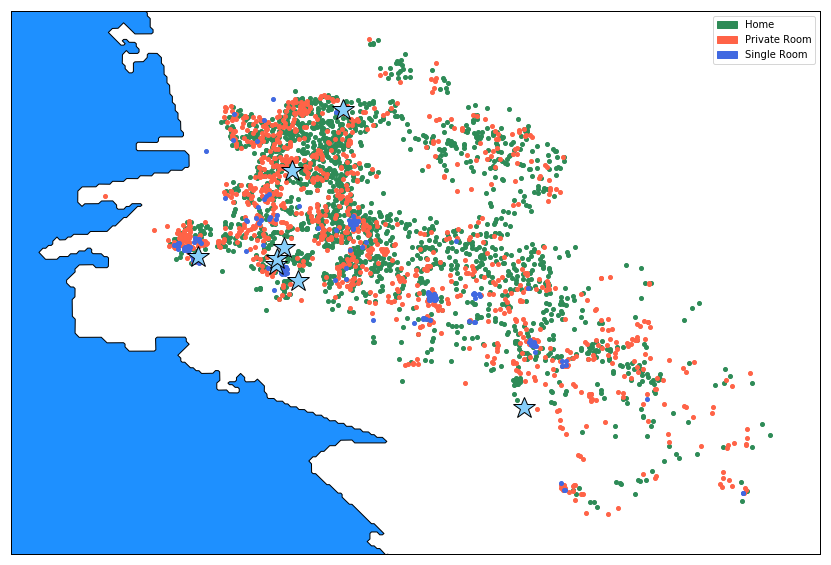

In [16]:
plt.figure(figsize=(20, 10))

# Initialize Basemap with longitude/latitude extents of the city of Oakland
ll = [37.715394, -122.351381]
ur = [37.878177, -122.108927]

oakmap = Basemap(llcrnrlon=ll[1], 
                 llcrnrlat=ll[0],
                 urcrnrlon=ur[1], 
                 urcrnrlat=ur[0],
                 projection='gall',
                 resolution='f', epsg=4269)

# Draw the city
oakmap.drawcoastlines()
oakmap.drawcountries()
oakmap.fillcontinents(color = 'w')
oakmap.drawmapboundary(fill_color='dodgerblue')

# Extract the latitude and longitudes of the room types
home_long, home_lat = oakmap(homes['longitude'], homes['latitude'])
proom_long, proom_lat = oakmap(priv_rooms['longitude'], priv_rooms['latitude'])
sroom_long, sroom_lat = oakmap(shar_rooms['longitude'], shar_rooms['latitude'])

# Pre-determined latitude and longitudes of Oakland Bart stations
bart_lat = [37.759186, 
            37.848407, 
            37.830242, 
            37.797313,
            37.804508,
            37.802175,
            37.803869,
            37.806992]

bart_long = [-122.197585,
             -122.251871,
             -122.267203,
             -122.265287,
             -122.295312,
             -122.271978,
             -122.271617,
             -122.269513]

blo, bla = oakmap(bart_long, bart_lat)

# Plot the room types by room type, plot the bar stations on the map
oakmap.plot(home_long, home_lat, 'o', color='seagreen', markersize=4)
oakmap.plot(proom_long, proom_lat, 'o', color='tomato', markersize=4)
oakmap.plot(sroom_long, sroom_lat, 'o', color='royalblue', markersize=4)
oakmap.plot(blo, bla, '*', color='lightskyblue', markeredgecolor='k', markersize=23)

# Create legend
Home = mpatches.Patch(color='seagreen', label='Home')
PRoom = mpatches.Patch(color='tomato', label='Private Room')
SRoom = mpatches.Patch(color='royalblue', label='Single Room')
plt.legend(handles=[Home, PRoom, SRoom], loc=1)

plt.savefig('Figures\\oak_basemap_proptype.pdf');

We now have a general idea of the locations of the listings, the room type makeup of the listings, as well as the locations of the bart stations! It might be an interesting exercise to do the same plot with the listings divided into groups that reflect price. One thing to point out is that the listings seem to be more concentrated toward the more "city-like" neighbhorhoods within Oakland and are more sparse towards the southeast area of the city.

In [17]:
# Split the listings by price
print(listings_data['price'].describe())

# Obtained quartile cutoffs
low = 63
medium = 95
high = 150

# Bucket the listings based on the prices
cheap = listings_data[listings_data['price'] < low]
cnormal = listings_data[(listings_data['price'] > low) & (listings_data['price'] < medium)]
enormal = listings_data[(listings_data['price'] > medium) & (listings_data['price'] < high)]
expensive = listings_data[listings_data['price'] > high]

count    3211.000000
mean      130.070694
std       163.929172
min         0.000000
25%        63.000000
50%        95.000000
75%       150.000000
max      3150.000000
Name: price, dtype: float64


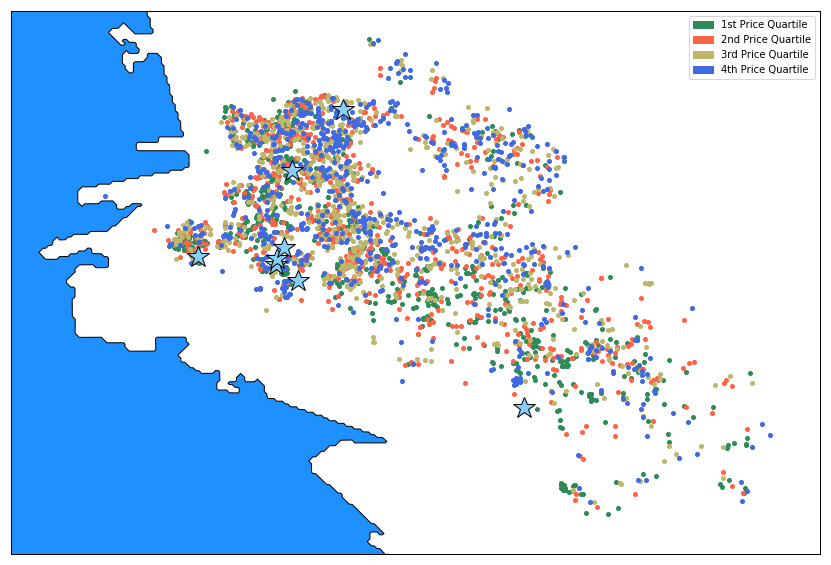

In [18]:
plt.figure(figsize=(20,10))

# Initialize Basemap with longitude/latitude extents of the city of Oakland
ll = [37.715394, -122.351381]
ur = [37.878177, -122.108927]

oakmap = Basemap(llcrnrlon=ll[1], 
                 llcrnrlat=ll[0],
                 urcrnrlon=ur[1], 
                 urcrnrlat=ur[0],
                 projection='gall',
                 resolution='f', epsg=4269)

# Draw the city
oakmap.drawcoastlines()
oakmap.drawcountries()
oakmap.fillcontinents(color = 'w')
oakmap.drawmapboundary(fill_color='dodgerblue')

# Extract the latitude and longitudes of the listings associated with different prices
cheap_long, cheap_lat = oakmap(cheap['longitude'], cheap['latitude'])
cnormal_long, cnormal_lat = oakmap(cnormal['longitude'], cnormal['latitude'])
enormal_long, enormal_lat = oakmap(enormal['longitude'], enormal['latitude'])
expen_long, expen_lat = oakmap(expensive['longitude'], expensive['latitude'])

# Pre-determined latitude and longitudes of Oakland Bart stations
bart_lat = [37.759186, 
            37.848407, 
            37.830242, 
            37.797313,
            37.804508,
            37.802175,
            37.803869,
            37.806992]

bart_long = [-122.197585,
             -122.251871,
             -122.267203,
             -122.265287,
             -122.295312,
             -122.271978,
             -122.271617,
             -122.269513]

blo, bla = oakmap(bart_long, bart_lat)

# Plot the rooms by price quartile, plot the bart station
oakmap.plot(cheap_long, cheap_lat, 'o', color='seagreen', markersize=4)
oakmap.plot(cnormal_long, cnormal_lat, 'o', color='tomato', markersize=4)
oakmap.plot(enormal_long, enormal_lat, 'o', color='darkkhaki', markersize=4)
oakmap.plot(expen_long, expen_lat, 'o', color='royalblue', markersize=4)
oakmap.plot(blo, bla, '*', color='lightskyblue', markeredgecolor='k', markersize=23)

# Create legend
Cheap = mpatches.Patch(color='seagreen', label='1st Price Quartile')
CNormal = mpatches.Patch(color='tomato', label='2nd Price Quartile')
ENormal = mpatches.Patch(color='darkkhaki', label='3rd Price Quartile')
Expen = mpatches.Patch(color='royalblue', label='4th Price Quartile')
plt.legend(handles=[Cheap, CNormal, ENormal, Expen], loc=1)

plt.savefig('Figures\\oak_basemap_priceQ.pdf')

I was expecting to see some visibily apparent price-location relationship here, maybe by neighborhood or by proximity to a BART station, but there does not seem to be anything of the sort. Let's create some more visualizations - next I'd like to examine the number of listings by neighborhood.

In [19]:
listings_data.groupby('neighbourhood_cleansed').count().shape[0]

124

There are 124 neighborhoods in total!

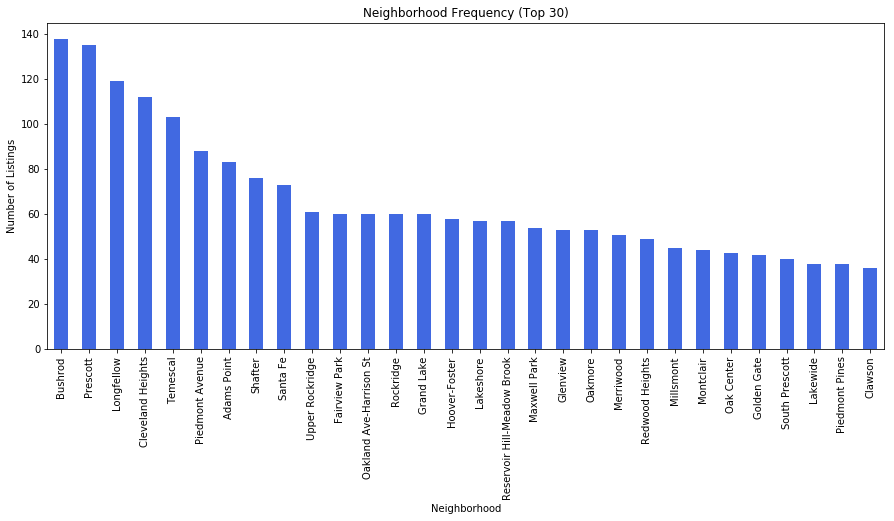

In [20]:
# Obtain the 30 neighborhoods with the most listings
neighborhood_freq = listings_data['neighbourhood_cleansed'].value_counts().head(30)

# Plot bar graph
neighborhood_freq.plot(kind='bar', 
                       figsize=(15, 6), 
                       color='royalblue')

# Change plot specifications
plt.title('Neighborhood Frequency (Top 30)')
plt.rc('font', size=10)
plt.xlabel('Neighborhood')
plt.ylabel('Number of Listings')

plt.savefig('Figures\\neighborhood_freq.pdf');

The figure above gives us a general idea of the most popular neighborhoods in Oakland in terms of the number of Airbnb listings contained.

Now let's take a look at listing prices:

In [21]:
listings_data['price'].mean()

130.07069448769855

It also may be a useful exercise to examine the mean price per neighborhood:

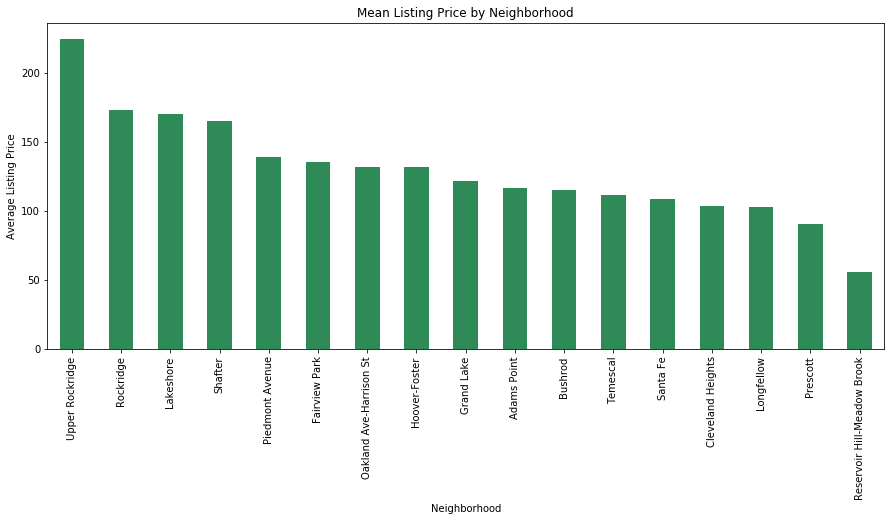

In [22]:
# Obtain the 30 most expensive neighbhoords
mean_neighborhood_prices = listings_data.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)[listings_data['neighbourhood_cleansed'].value_counts() > 55]

# Plot bar graph
mean_neighborhood_prices.plot(kind='bar', 
                              figsize=(15, 6), 
                              color='seagreen')

# Change plot specifications
plt.title('Mean Listing Price by Neighborhood')
plt.rc('font', size=15)
plt.xlabel('Neighborhood')
plt.ylabel('Average Listing Price')

plt.savefig('Figures\\neighborhood_price.pdf');

Here, I've only elected to calculate the mean listings price by neighorhood for neighborhoods that have more than the average number of listings per neighborhood. This would make the metric that we want to examine in order to characterize more robust to the presence of outliers. However, it's important to keep in mind that this still may be a bit misleading. For example:

In [23]:
UR = listings_data[listings_data['neighbourhood_cleansed'] == 'Upper Rockridge']
print('Shape: {}'.format(UR.shape))
print('Maximum Price in Upper Rockridge Neighborhood: {}'.format(UR['price'].max()))
print('Median Price in Upper Rockridge Neighborhood: {}'.format(UR['price'].median()))

Shape: (61, 24)
Maximum Price in Upper Rockridge Neighborhood: 2500.0
Median Price in Upper Rockridge Neighborhood: 149.0


The number of listings in the Upper Rockridge neighborhood (supposedly the most expensive neighborhood) is 61. Given that there are so few listings in the area compared to Bushrod, for example, the average listings price of the neighborhood is more easily skewed by the presence of outliers. We can see that this is may be occurring here, as the maximum listing price in the neighborhood (\\$2500.00) is multiple times more than the median listing price in the neighborhood (\\$149.00). 

It might be more useful, then, to simply view a DataFrame with the Neighborhood, average price, and the number of listings!

In [24]:
# Obtain the mean price of the listings in each neighborhood and packages as dataframe
nh_df = pd.DataFrame(listings_data.groupby('neighbourhood_cleansed')['price'].mean())

# Create a column containing the number of listings in each neighborhood
nh_df['Number of listings'] = listings_data.groupby('neighbourhood_cleansed').count()['id']
nh_df.head(20)

,price,Number of listings
neighbourhood_cleansed,,
Acorn-Acorn Industrial,96.200000,5
Adams Point,117.120482,83
Allendale,85.818182,22
Arroyo Viejo,51.363636,11
Bancroft Business-Havenscourt,100.000000,12
Bartlett,187.500000,2
Bella Vista,112.166667,6
Brookfield Village,58.857143,21
Bushrod,115.572464,138


Further analysis is needed in order to characterize "expensive" neighborhoods in Oakland. We have more metadata here to examine in order to get an idea of whether or not listings prices by neighborhood are driven by the neighborhoods themselves or other factors. Specifically, let's keep an eye out for characteristics such as the room type, property type, # of people the listing can accommodate, # of beds/bathrooms, etc. and how they affect listing price.

To start, let's take a look at the property and room type distributions.

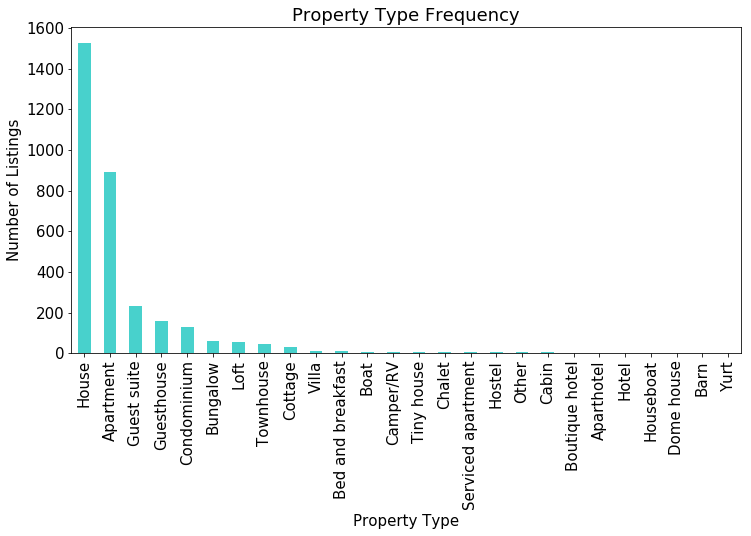

In [25]:
property_types = listings_data['property_type'].value_counts()
property_types.plot(kind='bar', 
                    figsize=(12, 6), 
                    color='mediumturquoise')

plt.title('Property Type Frequency')
plt.rc('font', size=15)
plt.xlabel('Property Type')
plt.ylabel('Number of Listings')

plt.savefig('Figures\\prop_type_freq.pdf');

It's apparent that the most common property types in descending order, are houses, apartments, guest suites, guesthouses and condominiums. There are also some other property types that would be less familiar to AirBnB users including "bungalows", "campers", and "dome houses".

With regards to room types, we already know that there are only 3 unique types (from the Basemap visualization). Because the Basemap visualization doesn't really give us a sense of the distribution of listings between those three unique room types, a small pie graph may be suitable for visualization here.

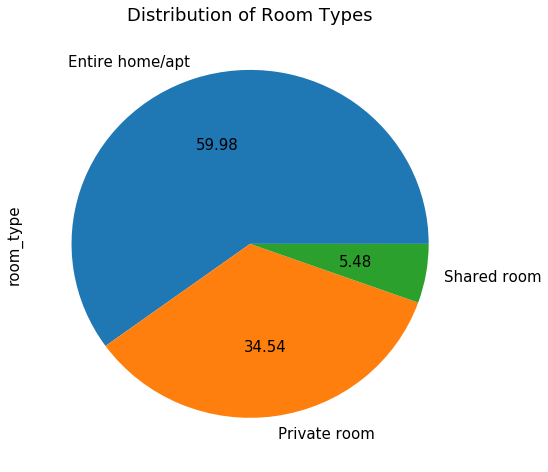

In [26]:
room_types.plot(kind='pie', 
                figsize=(8, 8), 
                autopct = '%.2f')

plt.title('Distribution of Room Types')
plt.rc('font', size=12)

plt.savefig('Figures\\room_type_distribution.pdf');

We can see that a majority (around 60%) of listings offer the entire residence. This majority is followed by around 34.5% of listings which offer private rooms, and the remaining 5.5% of listings that offer a shared room. Now that we have an idea of the distribution of listings across room types and property types, we should look at how mean prices vary across room type and property type combinations.

In [27]:
# Extract the room type, property type, and price columns
room_prop = listings_data[['room_type', 'property_type', 'price']]

# Group by room type and property type, then find mean price
mean_room_prop_prices = room_prop.groupby(['room_type', 'property_type']).mean()

# Essentially make into a pivot table, then fill nonexistent combinations with "NaC"
mean_room_prop_prices = mean_room_prop_prices.unstack().transpose().fillna('NaC') # Nac = Not a Combination
mean_room_prop_prices.to_csv('DataFrames\\mean_room_prop_prices.csv')

mean_room_prop_prices

room_type                Entire home/apt Private room Shared room
      property_type                                              
price Aparthotel                     NaC        149.5         NaC
      Apartment                  127.369      77.7569     47.6818
      Barn                           150          NaC         NaC
      Bed and breakfast              500      85.8889         NaC
      Boat                           217          NaC         NaC
      Boutique hotel                 NaC          149         NaC
      Bungalow                   142.714      69.8519         NaC
      Cabin                          100      78.3333         NaC
      Camper/RV                     76.8      77.3333         NaC
      Chalet                         351           85         NaC
      Condominium                141.771           81     28.1765
      Cottage                     129.75           85          28
      Dome house                     NaC           85         NaC
      Guest suite                122.332         79.6         NaC
      Guesthouse                 106.712      68.8571         NaC
      Hostel                          51      40.3333         NaC
      Hotel                          NaC          129         NaC
      House                       226.73        72.01     37.0859
      Houseboat                      120          NaC         NaC
      Loft                       203.972      84.2857        91.4
      Other                        157.5          100         NaC
      Serviced apartment           220.5           60         NaC
      Tiny house                 115.667           42         NaC
      Townhouse                  175.476      81.2308         NaC
      Villa                      1406.25      129.667         NaC
      Yurt                           NaC           50         NaC

Some observations: 
* The most expensive room and property combination on average is the entire residence of a Villa at 1406 dollars.
* The most cheap room and property combination on average is a shared room in a cottage at 28 dollars. (Both the most expensive and most cheap room/property type combinations are likely influenced by the presence of outliers)
* There are a lot of room type and property type combinations that don't exist in the data set! This makes sense - how often do you think shared rooms in campers are listed?

In general this table gives us somewhat of an idea of how price varies across room and property types. Now let's take a look at how the price varies with the number of reviews.

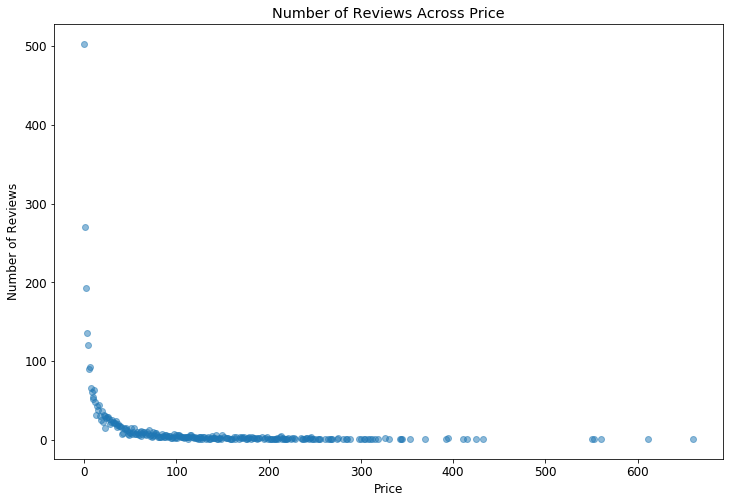

In [28]:
# Plot a scatter plot of the listings by the number of reviews and price
number_of_reviews = listings_data['number_of_reviews'].value_counts()
number_of_reviews.plot(style = 'o', 
                       figsize = (12, 8), 
                       alpha=0.5) # So that we can see density

plt.title('Number of Reviews Across Price')
plt.xlabel('Price')
plt.ylabel('Number of Reviews')

plt.savefig('Figures\\reviews_across_price.pdf');

It appears that the listings with the most reviews are within the 40 to 250 dollar price range. This makes sense as the number of reviews can be roughly considered to be the number of times a listing has been booked. We can expect that the most reasonably priced, affordable listings have higher traffic. One problem with this assumption: the number of reviews is likely to be a conservative estimate of the actual number of bookings.

Just for fun, I've outputted the description of the listing with the most reviews:

In [29]:
listings_data.iloc[353]['description']

'Liberty is a classic twin masted traditional sailing yacht with all the amenities of a small apartment. A cozy summer or winter retreat. The atmosphere aboard is warm, romantic and truly unique. She has been lovingly restored over the past 6 years. Liberty is a fully restored Tayana 37 sailing ketch and is nestled in the shadow of the historic Quinns lighthouse restaurant/pub in the quaint gardens of Embarcadero Cove marina with free parking available. Less than a mile from the Mom and Pop stores, bars and restaurants that line the beautiful streets of Alameda. Under 2 miles in the other direction will find you in the Downtown historic Oakland area. The yacht has a wonderful outside cockpit area which is great for enjoying wine, listening to music, watching the sunsets or just enjoying a morning coffee. The interior is lavished with fine teak, brass lamps and cozy seating, making it a memorable atmosphere unique only to a sailboat. The bathroom has a shower and toilet along with wash 

Now let's take a look at the amenities. First, let's examine what the amenities for a listing look like:

In [30]:
listings_data['amenities'][0]

'{TV,"Cable TV",Internet,Wifi,Kitchen,"Free street parking",Heating,"Family/kid friendly",Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit","Fire extinguisher",Essentials,Shampoo,"Lock on bedroom door",Hangers,"Hair dryer",Iron,"translation missing: en.hosting_amenity_50","Self check-in","Building staff","Hot water",Microwave,"Coffee maker",Refrigerator,"Dishes and silverware","Cooking basics",Oven,Stove,"Garden or backyard"}'

It's a bit of a mess. The entry is a string that starts and ends with curly braces and has quotation marks around certain amenities and not others. And if we're looking to compare amenities across listings, we need a way to count the number of amenities for each listing and use a standardized form to see if there are common amenities between listings. We should also take a look at an example entry to ensure that the amenities and counts have been processed correctly.

In [31]:
# Create a list of amenities 
listings_data['amenities_list']= listings_data['amenities'].apply(lambda x: x[1:-1].replace('"','').lower().split(','))

# Also count the number of amenities
listings_data['number_of_amenities'] = listings_data['amenities_list'].apply(len)

listings_data.amenities_list[0] # Let's see how this looks

['tv',
 'cable tv',
 'internet',
 'wifi',
 'kitchen',
 'free street parking',
 'heating',
 'family/kid friendly',
 'washer',
 'dryer',
 'smoke detector',
 'carbon monoxide detector',
 'first aid kit',
 'fire extinguisher',
 'essentials',
 'shampoo',
 'lock on bedroom door',
 'hangers',
 'hair dryer',
 'iron',
 'translation missing: en.hosting_amenity_50',
 'self check-in',
 'building staff',
 'hot water',
 'microwave',
 'coffee maker',
 'refrigerator',
 'dishes and silverware',
 'cooking basics',
 'oven',
 'stove',
 'garden or backyard']

This looks much more workable! It might be a useful exercise to see which amenities are most frequently included among listings.

In [32]:
# Add the amenities to a list
full_list = []
for words in listings_data.amenities_list:
    full_list += words

# Use counter to count the most frequent elements in a list and display the top 20 in a DataFrame
amenities_count = Counter(full_list) 
top20 = amenities_count.most_common()[:21]
top20df = pd.DataFrame(top20, columns=['Amenity', 'Frequency'])
top20df.to_csv('DataFrames\\top_20_amenities.csv', index=False)

top20df.set_index('Amenity')

,Frequency
Amenity,
wifi,3158
essentials,3050
smoke detector,3019
heating,2957
kitchen,2896
carbon monoxide detector,2635
hangers,2597
shampoo,2418
laptop friendly workspace,2398


It's not very surprising to see "Wifi" as the most common amenity to be included in the listings of this data set. 3158 out of 3211 have it listed as an amenity! Following Wifi is what Airbnb considers "essentials", which from the "hosting help" portion of their website lists as "toilet paper, soap, one towel per guest, one pillow per guest, and linens for each guest bed". It's interesting to me that "essentials" doesn't include Wifi, given that Wifi is seemingly more common to include as an amenity!

Other common amenities offered in the listings include "smoke detector", "heating", "kitchen", "hangers", "iron", and more.

It also might be a useful exercise to do the same with the description column to see which words hosts use to describe their listing most frequently. Let's clean up the column first, then take a look at an example entry so that we can ensure that the column has been cleaned properly.

In [33]:
# Remove punctuation and make everything lowercase
listings_data['description_cleansed'] = listings_data['description'].apply(lambda x: re.sub(r'[^\w\s]','',x)).apply(lambda x : x.lower())
listings_data['description_cleansed'][0] # Let's see how this looks now

'this is a beautiful spacious guest house with 5 bedrooms and a lovely back yard garden hello my name is b and im a bay area artist and community organizer as owner and operator bloves guest house is a unique extension to my lifestyle of wellness and creativity catering to the visiting artist or business professional this guest house is a cute and spacious 5 bedroom apartment on the street level of my victorian home the prices listed are per room  centrally located in the bay area in a diverse urban neighborhood bloves guest house is minutes away from san francisco downtown oakland emeryville and berkeley there are 5 private rooms with a shared bathroom the kitchen is stocked with cookware dishes utensils refrigerator and stove  the living room is cozy and  theres a beautiful backyard garden  as the home owner im looking for guest that are  easy going respectful and clean up after themselves  the apartments amenities are   wireless high speed internet  '

In [34]:
# Function for removing stopwords from a list of words
def clean_words(column):
    full_list = []
    for words in column:
        words = words.split()
        words = [word for word in words if word not in stopwords.words('english')]
        
        full_list += words
    
    return full_list

# Use counter to count the most common words and display the top 20 in a DataFrame
words_count = Counter(clean_words(listings_data['description_cleansed'])) 
top20 = words_count.most_common()[:20]
top20df = pd.DataFrame(top20, columns=['Word', 'Frequency'])
top20df.set_index('Word', inplace=True)

top20df.to_csv('DataFrames\\word_freq_desc.csv')
top20df

,Frequency
Word,
room,3690
oakland,3113
home,2786
kitchen,2653
bart,2528
bedroom,2362
house,2206
private,2117
bed,2070


The most common words used in the descriptions of the listings are "room", "oakland", "home", "kitchen", and "bart". It's also interesting to note that "San" and "Francisco" are very common words (within the top 20 most frequent words) in the descriptions of the listings - which may indicate that proximity to San Francisco is a strong selling point for Oakland AirBnB listings in general.

It might be an interesting exercise to do this with the "access" column to see what words hosts most commonly use to describe how to access their properties.

In [35]:
# Remove punctuation and make everything lowercase
listings_data['access_cleansed'] = listings_data['access'].apply(lambda x: re.sub(r'[^\w\s]','',x)).apply(lambda x : x.lower())
listings_data['access_cleansed'][0] # Let's see how this looks now

'guest have access to kitchen and shared bathroom there is also a wonderful backyard garden with a picnic table and benches a sun deck a flower and vegetable garden and a stage that can be used for rehearsals exercise  or just relaxing in the shade'

In [36]:
# Use the defined function above to apply the same treatment to the access_cleansed column
access_word_list = clean_words(listings_data['access_cleansed'])

# Use counter to count the most common words and display the top 20 in a DataFrame
words_count = Counter(access_word_list) 
top20 = words_count.most_common()[:21]
top20df = pd.DataFrame(top20, columns=['Word', 'Frequency'])
top20df.set_index('Word', inplace=True)

# Drop the 'missing' word as it is the filler word for missing entires
top20df.drop('missing', inplace=True)
top20df.to_csv('DataFrames\\word_freq_access.csv')
top20df

,Frequency
Word,
room,1182
access,1152
kitchen,951
guests,711
living,593
use,590
house,578
private,540
bathroom,479


I understand now that finding the most commonly used words in the description for how to access the property isn't the best way to gain an understanding of how properties are typically accessed. 

## Data Preparation for Modeling and Exploratory Data Analysis

Because some features present string values, and regression / other calculations that we can make on the data can only be done on numerical values, we have to prepare and slice the data accordingly for modeling.

Let's first extract only the numerical value columns needed for modeling as well as columns that we could make into numerical values.

In [37]:
modeling_cols = ['id', 
                 'host_response_time', 
                 'host_response_rate', 
                 'host_is_superhost', 
                 'room_type', 
                 'property_type',
                 'accommodates', 
                 'bathrooms', 
                 'beds', 
                 'bedrooms', 
                 'price', 
                 'instant_bookable', 
                 'cancellation_policy',
                 'review_scores_rating',
                 'number_of_reviews', 
                 'number_of_amenities']

listings_md = listings_data[modeling_cols]
listings_md.set_index('id', inplace=True)
listings_md.head()

,host_response_time,host_response_rate,host_is_superhost,room_type,property_type,accommodates,bathrooms,beds,bedrooms,price,instant_bookable,cancellation_policy,review_scores_rating,number_of_reviews,number_of_amenities
id,,,,,,,,,,,,,,,
3083,within a few hours,90.0,f,Private room,House,2,1.0,1.0,1.0,65.0,f,strict_14_with_grace_period,90.0,34,32
5739,within an hour,100.0,t,Entire home/apt,Guest suite,2,1.0,1.0,1.0,100.0,f,moderate,99.0,227,31
11022,within an hour,100.0,t,Entire home/apt,Guest suite,3,1.0,1.0,1.0,141.0,t,strict_14_with_grace_period,95.0,120,37
13291,within a few hours,100.0,f,Private room,Bungalow,1,1.0,1.0,1.0,70.0,f,moderate,94.0,58,24
24916,within a few hours,90.0,f,Entire home/apt,Guest suite,3,1.0,2.0,0.0,91.0,t,strict_14_with_grace_period,90.0,103,34


There's still work to be done here. For some of these columns, we need to create sets indicator variables that represent the values within each of the columns.

In [38]:
# Create dummies, and fill missing values with 0
listings_md = pd.get_dummies(listings_md)
listings_md.fillna(0, inplace=True)

# Drop collinear columns (use not being a superhost and not being instantly bookable as references)
listings_md.drop(columns=['host_is_superhost_f', 'instant_bookable_f'], axis=1, inplace=True)
listings_md.to_csv('DataFrames\\listings_processed.csv')

listings_md.head()

,host_response_rate,accommodates,bathrooms,beds,bedrooms,price,review_scores_rating,number_of_reviews,number_of_amenities,host_response_time_a few days or more,...,property_type_Serviced apartment,property_type_Tiny house,property_type_Townhouse,property_type_Villa,property_type_Yurt,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period
id,,,,,,,,,,,,,,,,,,,,,
3083,90.0,2,1.0,1.0,1.0,65.0,90.0,34,32,0,...,0,0,0,0,0,0,0,0,0,1
5739,100.0,2,1.0,1.0,1.0,100.0,99.0,227,31,0,...,0,0,0,0,0,0,0,1,0,0
11022,100.0,3,1.0,1.0,1.0,141.0,95.0,120,37,0,...,0,0,0,0,0,1,0,0,0,1
13291,100.0,1,1.0,1.0,1.0,70.0,94.0,58,24,0,...,0,0,0,0,0,0,0,1,0,0
24916,90.0,3,1.0,2.0,0.0,91.0,90.0,103,34,0,...,0,0,0,0,0,1,0,0,0,1


Let's take a final look at all of the columns themselves as well as the number of columns.

In [39]:
listings_md.columns

Index(['host_response_rate', 'accommodates', 'bathrooms', 'beds', 'bedrooms',
       'price', 'review_scores_rating', 'number_of_reviews',
       'number_of_amenities', 'host_response_time_a few days or more',
       'host_response_time_missing', 'host_response_time_within a day',
       'host_response_time_within a few hours',
       'host_response_time_within an hour', 'host_is_superhost_t',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'property_type_Aparthotel',
       'property_type_Apartment', 'property_type_Barn',
       'property_type_Bed and breakfast', 'property_type_Boat',
       'property_type_Boutique hotel', 'property_type_Bungalow',
       'property_type_Cabin', 'property_type_Camper/RV',
       'property_type_Chalet', 'property_type_Condominium',
       'property_type_Cottage', 'property_type_Dome house',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_Hotel', '

In [40]:
listings_md.shape

(3211, 49)

### Examining the Test Variable (price)

In [41]:
listings_md.price.describe()

count    3211.000000
mean      130.070694
std       163.929172
min         0.000000
25%        63.000000
50%        95.000000
75%       150.000000
max      3150.000000
Name: price, dtype: float64

Now that we have some basic descriptive stats on price, let's see how it's distributed.


 mu = 130.07 and sigma = 163.90

Skewness: 8.878168
Kurtosis: 114.250026


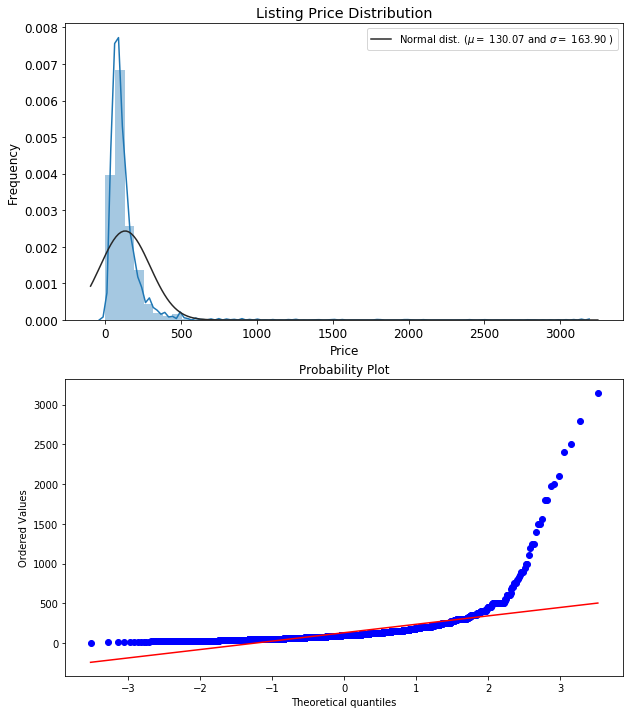

In [42]:
# Plot specifications
plt.figure(figsize=(10, 12))
plt.subplot(2, 1, 1)

# Create the distplot
sns.distplot(listings_md['price'], fit=norm);

# Calculate the mean and std deviation, display them on the plot and print them
(mu, sigma) = norm.fit(listings_md['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.title('Listing Price Distribution')
mpl.rc('font', size=10)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

# Create Normal QQ Plot
plt.subplot(2, 1, 2)
res = stats.probplot(listings_md['price'], plot=plt)

plt.savefig('Figures\\listings_price_dist_qqplot.pdf')

print("Skewness: %f" % listings_md['price'].skew())
print("Kurtosis: %f" % listings_md['price'].kurt())

We can see that price has substantially high right skew and a very sharp peak in the distribution around the mean as displayed in the histogram. All in all, there is heavy deviation in the distribution of price from the normal distirbution. We'll have to make changes to account for these measurements later.

### Feature Analysis

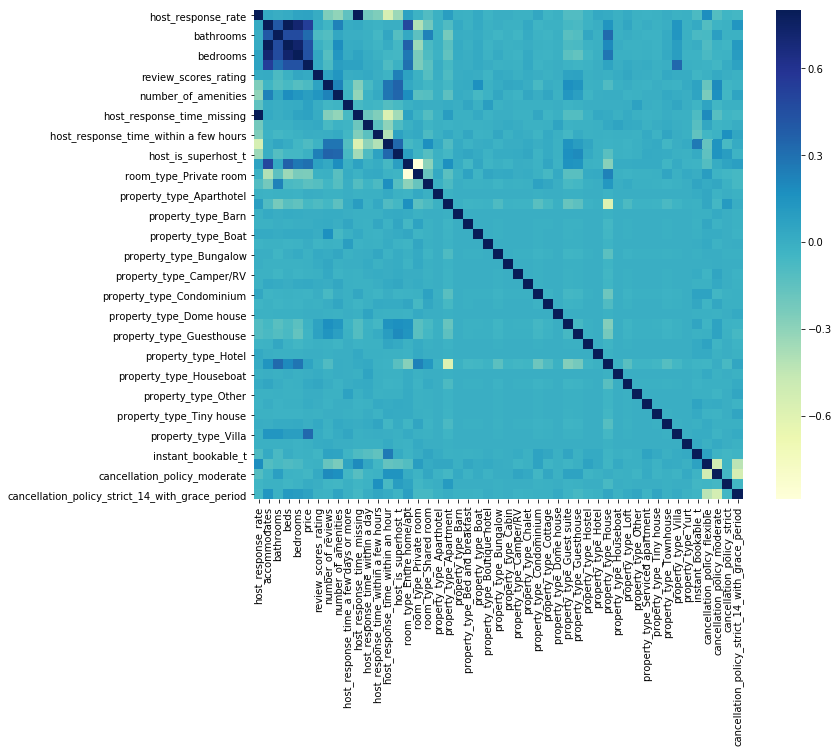

In [43]:
# Create correlation matrix
corrmat = listings_md.corr()
f, ax = plt.subplots(figsize=(12, 9))
heatmap = sns.heatmap(corrmat, vmax=.8, square=True, cmap="YlGnBu")

heatmap.figure.savefig('Figures\\corr_matrix.pdf');

It's now very obvious to me that there are high correlations between the number of accommodates, bedrooms, beds, and bathrooms. I don't think that this will be problematic (there aren't that many features, and we aren't using a model that is incredibly sensitive to these types of relationships). Let's take a look at the 8 most correlated features with price.

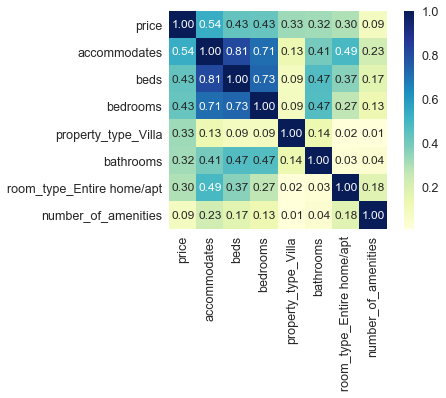

In [44]:
# Top 8 Heatmap
k = 8 #number of variables for heatmap
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(listings_md[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values, cmap="YlGnBu")

hm.figure.savefig('Figures\\corr_matrix_top8.pdf');

Let's also take a closer look at how the number of accommodates (the most correlated feature) relates to price:

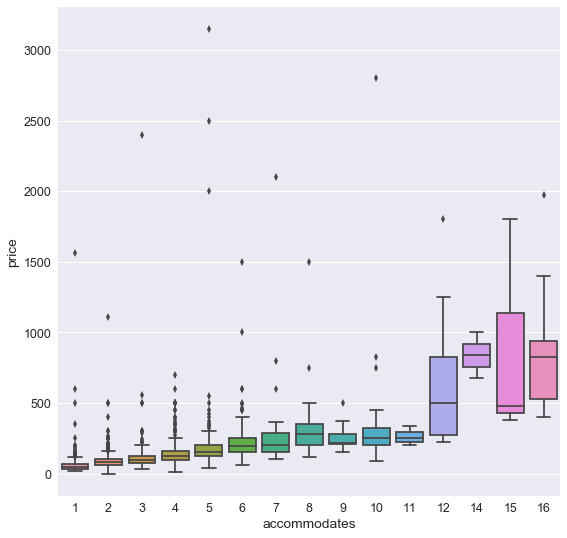

In [45]:
plt.figure(figsize=(9,9))
sns.boxplot(x=listings_md['accommodates'], y=listings_md.price)

plt.savefig('Figures\\#acc_price_boxplot.pdf');

For the most part, this relationship is relatively linear, and it makes sense. The more accommodates, the more expensive the listing. We do observe the presence of around 10 outliers or so, where some of the highest prices are observed for listings that offer residence for a relatively low number of accommodates ($3000+ for 5 accommodates for ex). We do not observe outliers that may be potentially harmful to our models, as there do not appear to be listings that offer residence for a high number of accommodates that cost very little (which can very much skew estimates in directions that are intuitively incorrect). Removing all outliers is likely to be harmful to our model in the case where there may be outliers in the testing data (when we eventually split the data). It is instead important to keep in mind to make our models robust to the presence of outliers. I'll remove the listings where the prices seem a bit too high (although we've seen that prices can vary wildly across a number of different factors such as property type, room type, etc). 

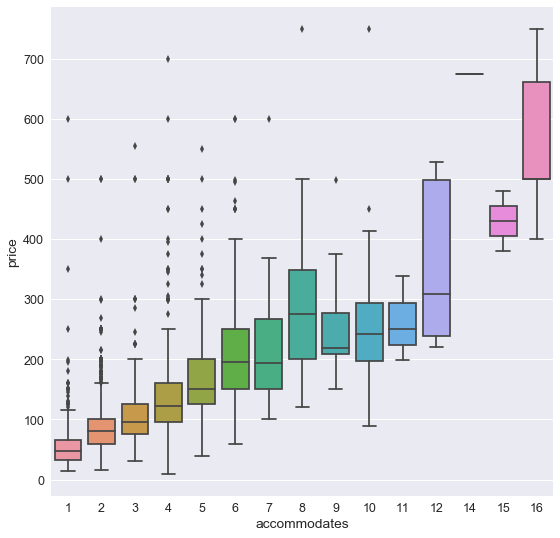

In [46]:
# Obtain the indices of the outliers and the listings without a price
outliers = listings_md[listings_md['price'] > 750].index
missingprice = listings_md[listings_md['price'] == 0].index

# Drop them
listings_md.drop(outliers, inplace=True)
listings_md.drop(missingprice, inplace=True)

plt.figure(figsize=(9,9))
sns.boxplot(x=listings_md['accommodates'], y=listings_md['price'])

plt.savefig('Figures\\#acc_price_boxplot_fixed.pdf');

In [47]:
listings_md.shape

(3183, 49)

We've dropped around 13 observations here!

### Dealing with Skew

As we saw before, our price variable is heavily right-skewed, and has a sharper than normal peak. We can make adjustments to address this and deal with other skewed numerical variables in our data accordingly.


 mu = 4.58 and sigma = 0.62

Skewness: 0.217173
Kurtosis: 0.084420


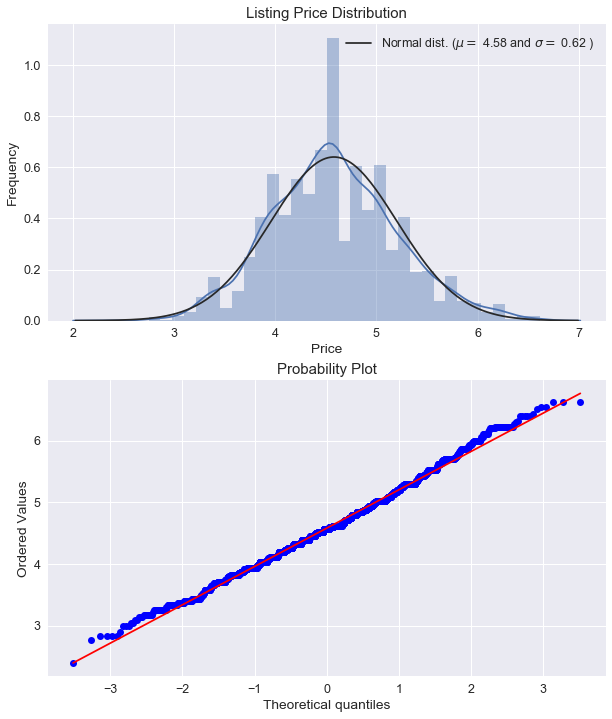

In [48]:
# Drop all prices of 0 (just in case), then log + 1 transform price
listings_md.price = np.log1p(listings_md['price'])

# Plot specifications
plt.figure(figsize=(10, 12))
plt.subplot(2, 1, 1)

# Create the distplot
sns.distplot(listings_md['price'], fit=norm);

# Calculate the mean and std deviation, display them on the plot and print them
(mu, sigma) = norm.fit(listings_md['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.title('Listing Price Distribution')
mpl.rc('font', size=10)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

# Create Normal QQ Plot
plt.subplot(2, 1, 2)
res = stats.probplot(listings_md['price'], plot=plt)

plt.savefig('Figures\\listings_price_dist_qqplot_transformed.pdf')

print("Skewness: %f" % listings_md['price'].skew())
print("Kurtosis: %f" % listings_md['price'].kurt())

This looks much better! One observation: We can see that the empirical data is a bit steeper in the QQ plot than the theoretical normal distribution. Thus, the empirical data is a bit more dispersed than the normal distribution (this makes sense as there was a very heavy right skew in the pre-transformation data).

Let's see if there are other skewed numerical variables in our data.

In [49]:
# Obtain all non categorical variables
numeric_vars = listings_md.dtypes[listings_md.dtypes != 'uint8'].index

# Find the skew for all of these variables
skewed_vars = listings_md[numeric_vars].apply(lambda x: skew(x))
skewed_vars

host_response_rate      0.996428
accommodates            1.872456
bathrooms               2.556999
beds                    2.321611
bedrooms                8.027390
price                   0.217070
review_scores_rating   -4.431028
number_of_reviews       3.650112
number_of_amenities     0.698141
dtype: float64

In [50]:
# For positively skewed variables
pos_skew = skewed_vars[skewed_vars > 0.75].dropna()
pos_skew_feats = pos_skew.index

# Apply a log transformation
for feat in pos_skew_feats:
    listings_md[feat] = np.log1p(listings_md[feat])

# For all negatively skewed variables
neg_skew = skewed_vars[skewed_vars < -0.75].dropna()
neg_skew_feats = neg_skew.index

# Apply a log transformation taking into account the negative skew by subtractive the value from the maximum
for feat in neg_skew_feats:
    listings_md[feat] = np.log1p(listings_md[feat].max() - listings_md[feat])
    
# Check skew of these variables again
skewed_vars = listings_md[numeric_vars].apply(lambda x: skew(x))
skewed_vars

host_response_rate     -1.614939
accommodates            0.586090
bathrooms               1.685145
beds                    1.079021
bedrooms                0.054225
price                   0.217070
review_scores_rating   -0.058372
number_of_reviews       0.108245
number_of_amenities     0.698141
dtype: float64

Take a look at the data one last time before modeling:

In [51]:
listings_md.to_csv('DataFrames\\listings_processed_transformed.csv')
listings_md.head()

,host_response_rate,accommodates,bathrooms,beds,bedrooms,price,review_scores_rating,number_of_reviews,number_of_amenities,host_response_time_a few days or more,...,property_type_Serviced apartment,property_type_Tiny house,property_type_Townhouse,property_type_Villa,property_type_Yurt,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period
id,,,,,,,,,,,,,,,,,,,,,
3083,4.510860,1.098612,0.693147,0.693147,0.693147,4.189655,2.397895,3.555348,32,0,...,0,0,0,0,0,0,0,0,0,1
5739,4.615121,1.098612,0.693147,0.693147,0.693147,4.615121,0.693147,5.429346,31,0,...,0,0,0,0,0,0,0,1,0,0
11022,4.615121,1.386294,0.693147,0.693147,0.693147,4.955827,1.791759,4.795791,37,0,...,0,0,0,0,0,1,0,0,0,1
13291,4.615121,0.693147,0.693147,0.693147,0.693147,4.262680,1.945910,4.077537,24,0,...,0,0,0,0,0,0,0,1,0,0
24916,4.510860,1.386294,0.693147,1.098612,0.000000,4.521789,2.397895,4.644391,34,0,...,0,0,0,0,0,1,0,0,0,1


## Modeling

Now let's use regularized regression models which we can easily implement using the scikit-learn library. First, let's import what we need and split the data.

In [52]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

Y = listings_md['price']
X = listings_md.drop('price', axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

It'll also be helpful to define a function that returns the cross-validation root mean squared error (rmse) so that we can very easily evaluate and compare our models.

In [53]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_error", cv = 5))
    return rmse

Let's start with L2 Ridge regularization:

In [54]:
ridgem = Ridge()

The regularization parameter for Ridge regression is alpha, which essentially measures the flexibility of our model. The higher it is, the less prone our model will be able to overfit at the cost of decreased flexibility. Let's take a look at the relationship between rmse and alpha using the model.

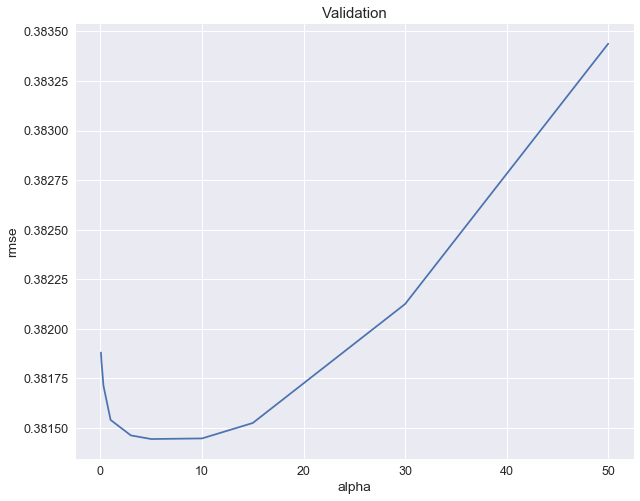

In [55]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(figsize = (10, 8))

plt.title('Validation')
plt.xlabel("alpha")
plt.ylabel('rmse')

plt.savefig('Figures\\L2_rmse_vs_alpha.pdf')

Note that there is a local minimum in the graph above. When alpha is too large, the regularization is too strong and the model cannot capture the complexity in the data. However, if we let the model be too flexible with an incredibly small alpha value, the model begins to overfit. Let's take a look at what the minimum achievable rmse value by manipulating alpha is:

In [56]:
cv_ridge.min()

0.3814444325603297

Let's try out the Lasso model now. Instead of manually manipulating alphas and testing, we can use the built in Lasso CV to ascertain the optimal value of alpha.

In [57]:
lassom = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, Y_train)
rmse_cv(lassom).mean()

0.3821638837158997

We can see that Lasso performs slightly worse. Therefore, we'll use ridge regression in order to predict on the test set. But before we do... 

One thing to note is that Lasso performs feature reduction for you automatically by setting the coefficients of features that it deems unimportant to 0. Let's take a look at how many were dropped, and which features seem to be the most important.

In [58]:
coef = pd.Series(lassom.coef_, index= X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 21 variables and eliminated the other 27 variables


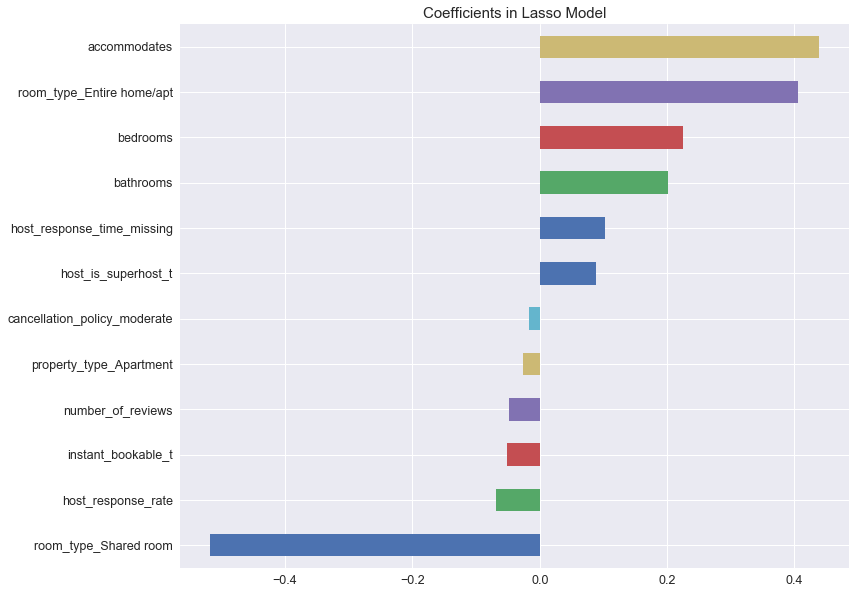

In [59]:
imp_coef = pd.concat([coef.sort_values().head(6), coef.sort_values().tail(6)])
mpl.rcParams['figure.figsize'] = (12, 10)
imp_coef.plot(kind = 'barh')
plt.title('Coefficients in Lasso Model')

plt.savefig('Figures\\lasso_feat_importance.pdf')

The most important positive feature is `accommodates`, which represents the number of people a listing can accommodate. This makes intuitive sense - the higher the number of people going to be given temporary residence, the higher the price. This feature is followed by a couple of categorical features that denote whether the listing is an entire home or apartment, whether the host responds within a few days, and whether that host is a superhost along with features that represent the number of bathrooms and bedrooms that the listing offers.

Now back to ridge regression:

In [60]:
# Instantiate a Ridge Regressor with the optimal value of alpha we determined earlier
ridgem = Ridge(alpha=5)

# Fit on the training set
ridgem.fit(X_train, Y_train);

Let's take a look at the residuals just in case.

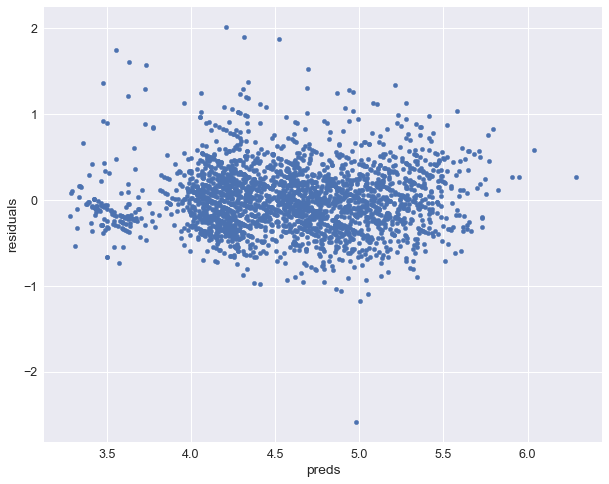

In [61]:
preds = pd.DataFrame({'preds':ridgem.predict(X_train), 'true':Y_train})
preds['residuals'] = preds['true'] - preds['preds']
preds.plot(x = 'preds', y = 'residuals', kind = 'scatter', figsize = (10, 8))

plt.savefig('Figures\\residuals.pdf')

The residuals look fine - there doesn't seem to be any visible trends between them and the predictions, and they don't appear to be too large in magnitude either.

Let's predict on the test set and see how off we are:

In [62]:
ridgepreds = ridgem.predict(X_test)

rmse = np.sqrt(mean_squared_error(Y_test, ridgepreds))
print("RMSE: {}".format(rmse))

RMSE: 0.3698936232019205


Let's apply `xgboost` here and see if we can get a lower rmse. The basic idea behind xgboost has to do with building weak models, making conclusions about the various feature importance parameters, and then using those conclusions to build a stronger model by capitalizing on misclassication error of previous models. 

In [63]:
# Instantiate an XGBoost Regressor
xg_reg = xgb.XGBRegressor(objective = 'reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 2, n_estimators = 300)

# Fit regressor to training set, and make predictions on the test set
xg_reg.fit(X_train, Y_train)
XGBpreds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(Y_test, XGBpreds))
print("RMSE: {}".format(rmse))

[17:37:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.3614151706430383


We were able to get a slightly smaller RMSE using the boosted regression on the testing set. Let's take a look at the ridge regression predictions vs. the XGB Regression predictions.

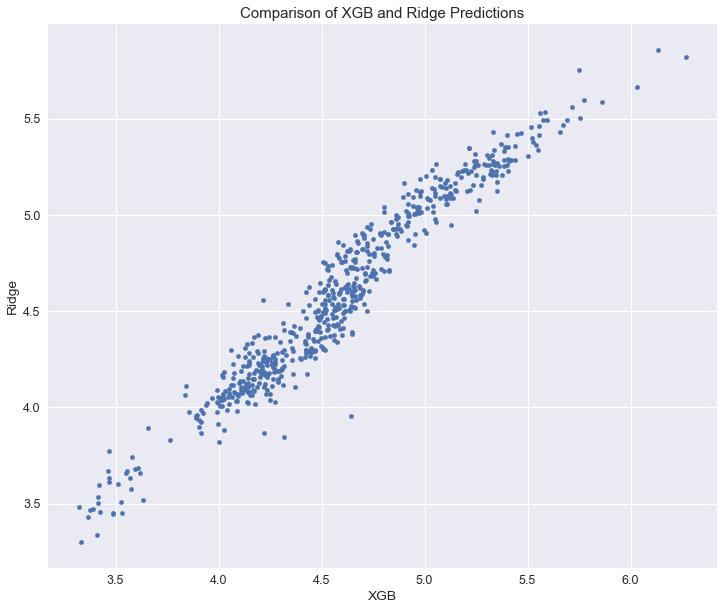

In [64]:
predictions = pd.DataFrame({"XGB":XGBpreds, "Ridge":ridgepreds})
predictions.plot(x = "XGB", y = "Ridge", kind = "scatter", title='Comparison of XGB and Ridge Predictions')

plt.savefig('Figures\\ridgepreds_vs_xgbpreds.pdf')

We see relatively good correspondence here, although our predictions are still log transformed, so differences in predictions of outliers is not visually apparent.

One way we can visualize our XGBoost regressor is by examining the importance of each feature column:

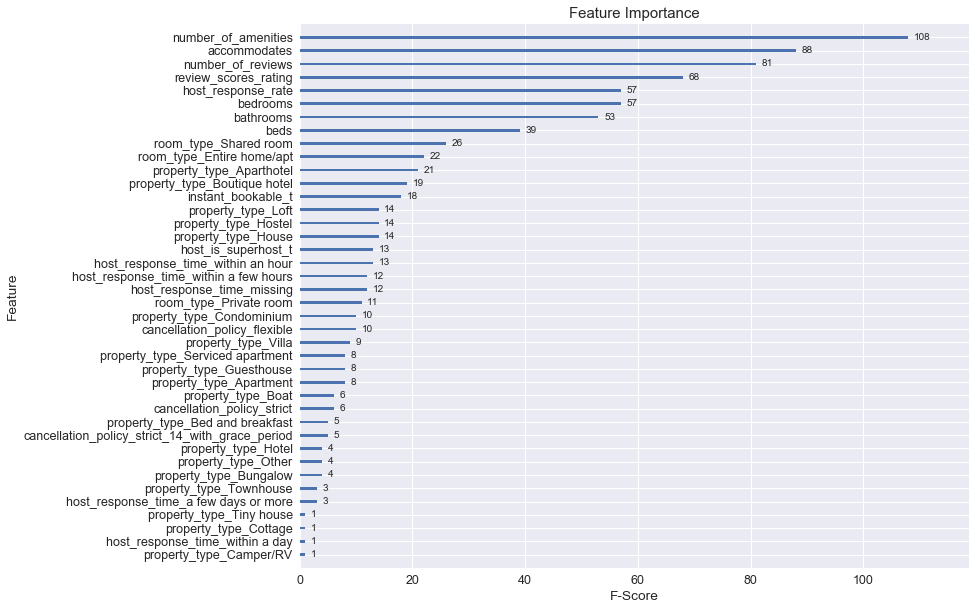

In [65]:
# Use the plot_importance method
xgb.plot_importance(xg_reg)

# Plot Specifications
plt.rcParams['figure.figsize'] = [12, 6]
plt.title('Feature Importance')
plt.rc('font', size=12)
plt.xlabel('F-Score')
plt.ylabel('Feature')

plt.savefig('Figures\\xgb_feat_importance.pdf')

The F-Score produced by this method is a very basic feature importance metric that counts the number of times a feature is split on (in the individual trees) while boosting. We can see that, contrary to feature importances ascertained in our Lasso model, the number of amenities is the most important feature according to our XGBregressor model. The number of reviews also holds a very high value of importance along with the review scores rating and host response rate. 

In order to build a more robust XGB model we should do a k-fold cross validation.

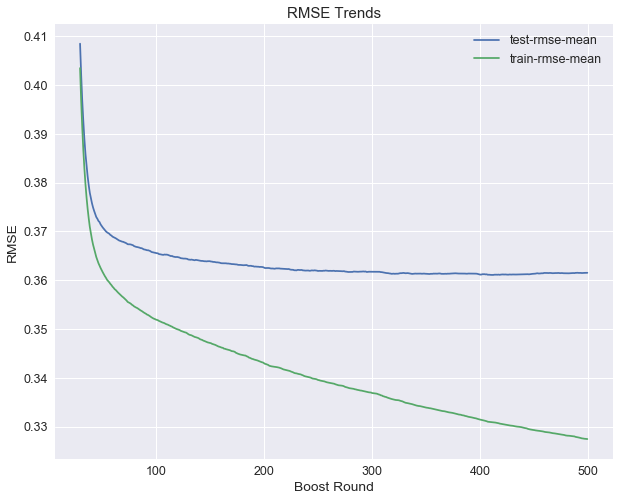

In [66]:
# Create the training DMatrix
dtrain = xgb.DMatrix(X, label = Y)

# Initialize parameters
params = {'max_depth':2, 'eta':0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=100, as_pandas=True)

# Plot the trends in testing and training rmse's relative to iteration
model.loc[30:, ['test-rmse-mean', 'train-rmse-mean']].plot(figsize = (10,8))
plt.title('RMSE Trends')
plt.xlabel('Boost Round')
plt.ylabel('RMSE')

plt.savefig('Figures\\cross_val_rmse.pdf')

We can see the final boosting round test RMSE below:

In [67]:
model['test-rmse-mean'].tail(1)

499    0.361532
Name: test-rmse-mean, dtype: float64

## Final Takeaways

In this analysis project, I analyzed more of the general trends with regards to of Airbnb listings in the city of Oakland, CA.

#### General Descriptive Stats
* There are 3211 Airbnb listings in the city of Oakland (in the dataset)
* The average price of these listings is \\$130.07
* There are 2288 unique hosts that have listings in the city of Oakland



#### Neighborhood Information
* The neighborhoods in Oakland that contain the most listings are Bushrod (138), Prescott (135), and Longfellow (119)
* The neighborhoods with more than 60 listings that have highest average price are Claremont (\\$388.78), Upper Rockridge (\\$225.00), and Trestle Glen (\\$192.06)
    * It's difficult to characterize the 3 "most expensive" neighbhorhoods as the number of listings per neighborhood is realtively small (around 58 on average), making mean neighborhood listing prices sensitive to the presence of outliers

#### Listing Characteristics
* Listings tend to be clustered around Bart stations
* Listing prices vary to a great extent across different property type and room type combinations (this makes intuitive sense)
    * For example, shared Rooms in apartments are \\$47.68 on average, whereas entire houses are \\$226.73 on average.
* The listings with the most reviews are within the \\$40 - \\$200 price range.
* The most common amenities offered by listings are (in order) wifi, "essentials" (which include toilet paper, soap, towels, pillows, and sheets), smoke detectors, and heating.
* A commonly used term in listings' descriptions is "San Francisco" suggesting that proximity to San Francisco is a draw to Oakland Airbnb listings.

#### Price Prediction
* The feature in the dataset that is the most correlated with listings price is the # of accommodates
* The most important features in determining listings price according to Lasso Regression are the # of accommodates, whether the listing offers an entire property or not, and the # of bedrooms and bathrooms
    * Whether or not the host is a superhost is also an important feature according to the Lasso model
* The most important features in determining listings price according to our XGBoost regressor are the # of amenities, the # of accommodates, and the # of the reviews
    * The host response rate and the review scores rating are also important features according to this model